In [ ]:
!pip install torch torchvision --quiet
!git clone https://github.com/FoundationVision/VAR.git 2>/dev/null || echo "Ya clonado"
%cd /content/VAR

# Descargar checkpoints si no existen
import os
os.makedirs('checkpoints', exist_ok=True)

if not os.path.exists('checkpoints/vae_ch160v4096z32.pth'):
    !wget -q https://huggingface.co/FoundationVision/var/resolve/main/vae_ch160v4096z32.pth -P checkpoints/
    print("VAE descargado")

if not os.path.exists('checkpoints/var_d24.pth'):
    !wget -q https://huggingface.co/FoundationVision/var/resolve/main/var_d24.pth -P checkpoints/
    print("VAR-d24 descargado")

print("✓ Setup completado")

/content/VAR
VAE descargado
VAR-d24 descargado
✓ Setup completado


In [ ]:
import sys
sys.path.insert(0, '/content/VAR')

import torch
import random
import numpy as np
from PIL import Image
from IPython.display import display

# Configurar dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando: {device}")

# Seed para reproducibilidad
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Usando: cpu


In [ ]:
from models import VQVAE, build_vae_var

# Parámetros del modelo VAR-d24
vae_ckpt = 'checkpoints/vae_ch160v4096z32.pth'
var_ckpt = 'checkpoints/var_d24.pth'
depth = 24  # d24 = 1.0B params

# Cargar VAE y VAR
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)  # escalas multi-resolución
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=depth, shared_aln=False,
)

# Cargar pesos
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)

vae.eval()
var.eval()
print("✓ Modelos cargados")



[constructor]  ==== flash_if_available=True (0/24), fused_if_available=True (fusing_add_ln=0/24, fusing_mlp=0/24) ==== 
    [VAR config ] embed_dim=1536, num_heads=24, depth=24, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.1 (tensor([0.0000, 0.0043, 0.0087, 0.0130, 0.0174, 0.0217, 0.0261, 0.0304, 0.0348,
        0.0391, 0.0435, 0.0478, 0.0522, 0.0565, 0.0609, 0.0652, 0.0696, 0.0739,
        0.0783, 0.0826, 0.0870, 0.0913, 0.0957, 0.1000]))

[init_weights] VAR with init_std=0.0147314
✓ Modelos cargados


Generando 6 imágenes...


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Clase 207, Imagen 0:


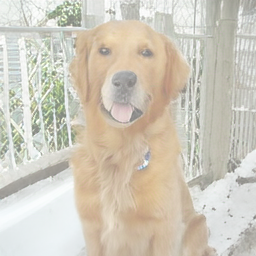

Clase 207, Imagen 1:


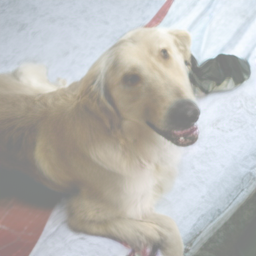

Clase 985, Imagen 0:


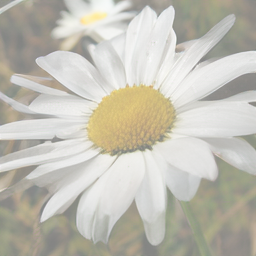

Clase 985, Imagen 1:


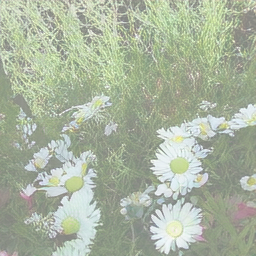

Clase 388, Imagen 0:


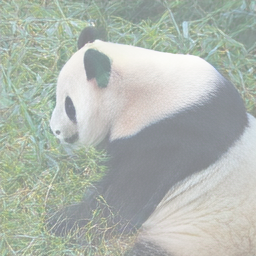

Clase 388, Imagen 1:


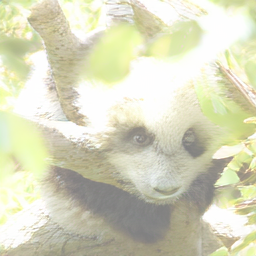


✓ Imágenes guardadas en /content/VAR/output/


In [ ]:

# -------------------------
# Lista de clases ImageNet interesantes:
# 207: golden retriever, 985: daisy, 388: panda,
# 979: valley, 33: loggerhead turtle, 88: macaw

class_labels = [207, 985, 388]  # Cambia estos números
num_imgs_per_class = 2
cfg_scale = 5.0  # Classifier-free guidance (más alto = más fidelidad a la clase)
top_p = 0.96
top_k = 900

print(f"Generando {len(class_labels) * num_imgs_per_class} imágenes...")

with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16):
        for class_idx in class_labels:
            # Generar imágenes para esta clase
            class_tensor = torch.tensor([class_idx] * num_imgs_per_class, device=device)

            # Muestreo autoregresivo
            images = var.autoregressive_infer_cfg(
                B=num_imgs_per_class,
                label_B=class_tensor,
                cfg=cfg_scale,
                top_p=top_p,
                top_k=top_k,
                more_smooth=False,
            )

            # Convertir a PIL y mostrar
            for i, img_tensor in enumerate(images):
                # Desnormalizar: de [-1, 1] a [0, 255]
                img = img_tensor.permute(1, 2, 0).cpu().numpy()
                img = ((img + 1) / 2 * 255).clip(0, 255).astype(np.uint8)
                pil_img = Image.fromarray(img)

                # Guardar
                filename = f'output/class{class_idx}_img{i}.png'
                os.makedirs('output', exist_ok=True)
                pil_img.save(filename)

                print(f"Clase {class_idx}, Imagen {i}:")
                display(pil_img)

print("\n✓ Imágenes guardadas en /content/VAR/output/")

GENERANDO GRÁFICAS DE RESULTADOS


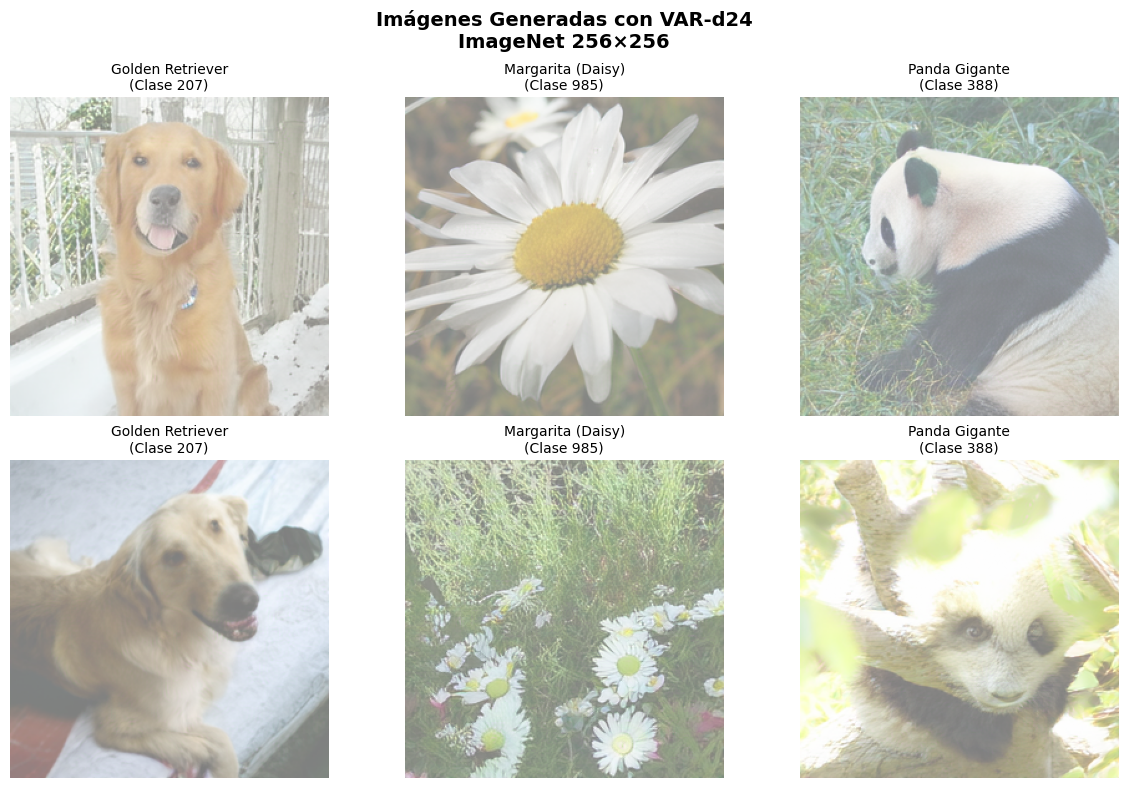

✓ Guardado: graficas/01_mosaico_resultados.png



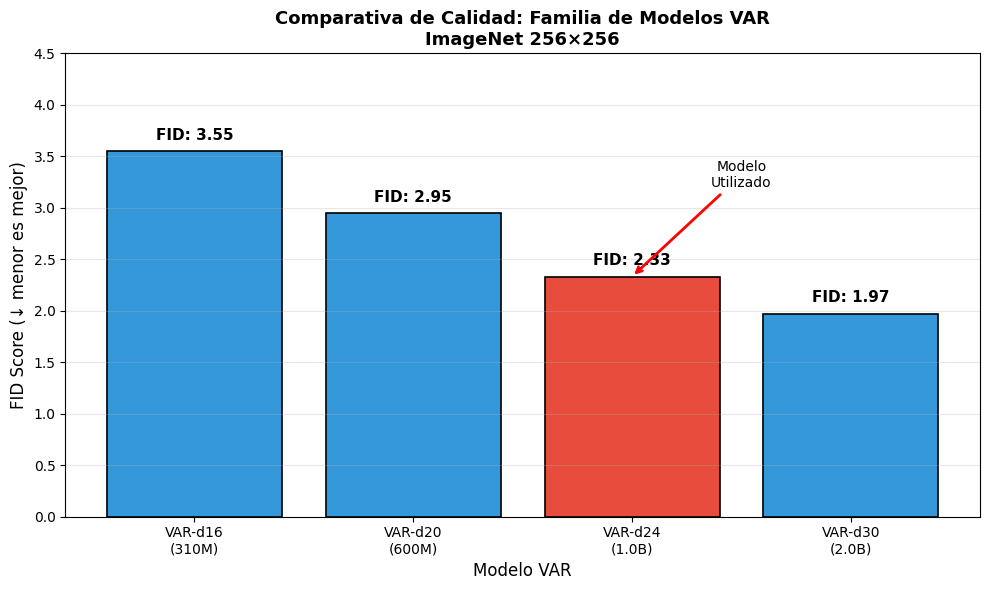

✓ Guardado: graficas/02_comparativa_fid.png



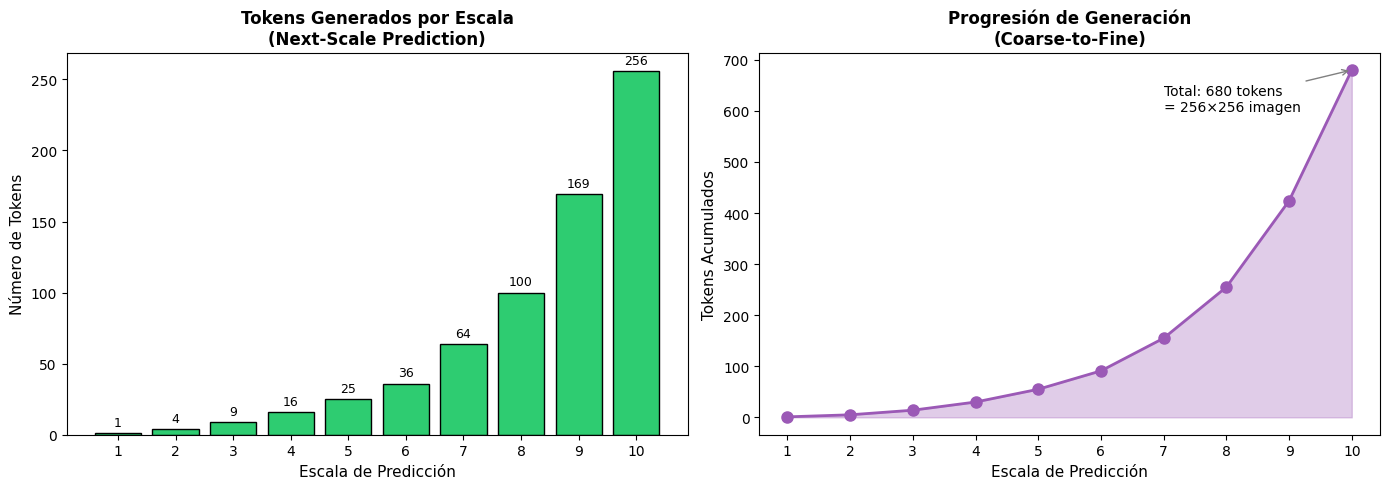

✓ Guardado: graficas/03_arquitectura_escalas.png



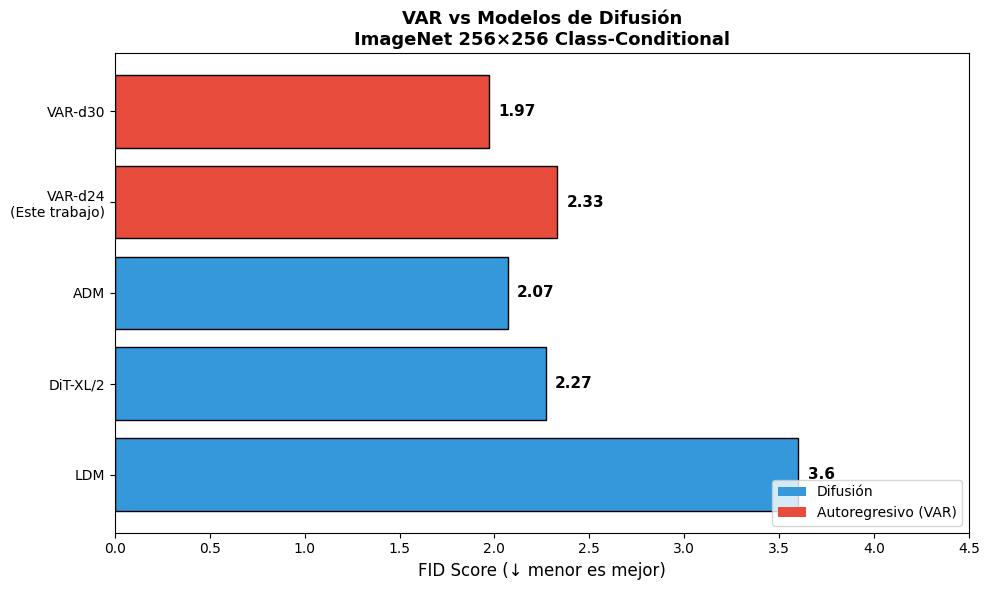

✓ Guardado: graficas/04_var_vs_difusion.png

✓ TODAS LAS GRÁFICAS GUARDADAS EN /content/VAR/graficas/

Archivos generados:
  📊 04_var_vs_difusion.png
  📊 01_mosaico_resultados.png
  📊 03_arquitectura_escalas.png
  📊 02_comparativa_fid.png


In [ ]:
# =============================================================================
# GRÁFICAS DE RESULTADOS - Ejecutar en Colab después de generar imágenes
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time

# Crear directorio para gráficas
os.makedirs('graficas', exist_ok=True)

# -----------------------------------------------------------------------------
# GRÁFICA 1: Mosaico de imágenes generadas
# -----------------------------------------------------------------------------
def crear_mosaico():
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Imágenes Generadas con VAR-d24\nImageNet 256×256', fontsize=14, fontweight='bold')

    clases = {
        207: 'Golden Retriever',
        985: 'Margarita (Daisy)',
        388: 'Panda Gigante'
    }

    for idx, (class_id, class_name) in enumerate(clases.items()):
        for img_num in range(2):
            row = img_num
            col = idx
            img_path = f'output/class{class_id}_img{img_num}.png'

            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                axes[row, col].imshow(img)
                axes[row, col].set_title(f'{class_name}\n(Clase {class_id})', fontsize=10)
            else:
                axes[row, col].text(0.5, 0.5, 'Imagen no\nencontrada',
                                   ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('graficas/01_mosaico_resultados.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Guardado: graficas/01_mosaico_resultados.png")

# -----------------------------------------------------------------------------
# GRÁFICA 2: Comparativa de modelos VAR (FID Score)
# -----------------------------------------------------------------------------
def grafica_fid_comparativa():
    modelos = ['VAR-d16\n(310M)', 'VAR-d20\n(600M)', 'VAR-d24\n(1.0B)', 'VAR-d30\n(2.0B)']
    fid_scores = [3.55, 2.95, 2.33, 1.97]
    colores = ['#3498db', '#3498db', '#e74c3c', '#3498db']  # Rojo para d24 (usado)

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(modelos, fid_scores, color=colores, edgecolor='black', linewidth=1.2)

    # Etiquetas en las barras
    for bar, fid in zip(bars, fid_scores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08,
                f'FID: {fid}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Marcar el modelo usado
    ax.annotate('Modelo\nUtilizado', xy=(2, 2.33), xytext=(2.5, 3.2),
                fontsize=10, ha='center',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

    ax.set_ylabel('FID Score (↓ menor es mejor)', fontsize=12)
    ax.set_xlabel('Modelo VAR', fontsize=12)
    ax.set_title('Comparativa de Calidad: Familia de Modelos VAR\nImageNet 256×256',
                 fontsize=13, fontweight='bold')
    ax.set_ylim(0, 4.5)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('graficas/02_comparativa_fid.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Guardado: graficas/02_comparativa_fid.png")

# -----------------------------------------------------------------------------
# GRÁFICA 3: Arquitectura Multi-Escala de VAR
# -----------------------------------------------------------------------------
def grafica_escalas():
    escalas = list(range(1, 11))
    resoluciones = [1, 2, 3, 4, 5, 6, 8, 10, 13, 16]
    tokens = [r**2 for r in resoluciones]
    tokens_acum = np.cumsum(tokens)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Subplot 1: Tokens por escala
    ax1.bar(escalas, tokens, color='#2ecc71', edgecolor='black')
    ax1.set_xlabel('Escala de Predicción', fontsize=11)
    ax1.set_ylabel('Número de Tokens', fontsize=11)
    ax1.set_title('Tokens Generados por Escala\n(Next-Scale Prediction)', fontsize=12, fontweight='bold')
    ax1.set_xticks(escalas)
    for i, (s, t) in enumerate(zip(escalas, tokens)):
        ax1.text(s, t + 5, f'{t}', ha='center', fontsize=9)

    # Subplot 2: Tokens acumulados
    ax2.plot(escalas, tokens_acum, 'o-', color='#9b59b6', linewidth=2, markersize=8)
    ax2.fill_between(escalas, tokens_acum, alpha=0.3, color='#9b59b6')
    ax2.set_xlabel('Escala de Predicción', fontsize=11)
    ax2.set_ylabel('Tokens Acumulados', fontsize=11)
    ax2.set_title('Progresión de Generación\n(Coarse-to-Fine)', fontsize=12, fontweight='bold')
    ax2.set_xticks(escalas)
    ax2.annotate(f'Total: {tokens_acum[-1]} tokens\n= 256×256 imagen',
                 xy=(10, tokens_acum[-1]), xytext=(7, 600),
                 fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.tight_layout()
    plt.savefig('graficas/03_arquitectura_escalas.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Guardado: graficas/03_arquitectura_escalas.png")

# -----------------------------------------------------------------------------
# GRÁFICA 4: VAR vs Difusión
# -----------------------------------------------------------------------------
def grafica_var_vs_difusion():
    modelos = ['LDM', 'DiT-XL/2', 'ADM', 'VAR-d24\n(Este trabajo)', 'VAR-d30']
    fid = [3.60, 2.27, 2.07, 2.33, 1.97]
    tipo = ['Difusión', 'Difusión', 'Difusión', 'Autoregresivo', 'Autoregresivo']
    colores = ['#3498db' if t == 'Difusión' else '#e74c3c' for t in tipo]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(modelos, fid, color=colores, edgecolor='black')

    for bar, f in zip(bars, fid):
        ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                f'{f}', va='center', fontsize=11, fontweight='bold')

    ax.set_xlabel('FID Score (↓ menor es mejor)', fontsize=12)
    ax.set_title('VAR vs Modelos de Difusión\nImageNet 256×256 Class-Conditional',
                 fontsize=13, fontweight='bold')
    ax.set_xlim(0, 4.5)

    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Difusión'),
                       Patch(facecolor='#e74c3c', label='Autoregresivo (VAR)')]
    ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig('graficas/04_var_vs_difusion.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Guardado: graficas/04_var_vs_difusion.png")

# -----------------------------------------------------------------------------
# EJECUTAR TODAS LAS GRÁFICAS
# -----------------------------------------------------------------------------
print("="*60)
print("GENERANDO GRÁFICAS DE RESULTADOS")
print("="*60)

crear_mosaico()
print()
grafica_fid_comparativa()
print()
grafica_escalas()
print()
grafica_var_vs_difusion()

print("\n" + "="*60)
print("✓ TODAS LAS GRÁFICAS GUARDADAS EN /content/VAR/graficas/")
print("="*60)

# Listar archivos generados
print("\nArchivos generados:")
for f in os.listdir('graficas'):
    print(f"  📊 {f}")

In [ ]:
# Comprimir todo en un ZIP
!zip -r evidencia_VAR.zip output/ graficas/ *.ipynb

# Descargar
from google.colab import files
files.download('evidencia_VAR.zip')



  adding: output/ (stored 0%)
  adding: output/class985_img0.png (deflated 0%)
  adding: output/class985_img1.png (deflated 0%)
  adding: output/class207_img1.png (deflated 0%)
  adding: output/class388_img0.png (deflated 0%)
  adding: output/class207_img0.png (deflated 0%)
  adding: output/class388_img1.png (deflated 0%)
  adding: graficas/ (stored 0%)
  adding: graficas/04_var_vs_difusion.png (deflated 21%)
  adding: graficas/01_mosaico_resultados.png (deflated 0%)
  adding: graficas/03_arquitectura_escalas.png (deflated 15%)
  adding: graficas/02_comparativa_fid.png (deflated 19%)
  adding: demo_sample.ipynb (deflated 61%)
  adding: demo_zero_shot_edit.ipynb (deflated 25%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>